DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:root:iterater 0


Start read data
读取数据花费了  0.005982875823974609  second 

开始训练

正在处理第 0 个特征
***第 0 个特征创建了分类器***
该分类器的误差率为： 0.10666666666666667
***第 0 个特征创建了分类器***
该分类器的误差率为： 0.09870646766169168
***第 0 个特征创建了分类器***
该分类器的误差率为： 0.09783469492897658
***第 0 个特征创建了分类器***
该分类器的误差率为： 0.09774015613561667
***第 0 个特征创建了分类器***
该分类器的误差率为： 0.09772991492130703
***第 0 个特征创建了分类器***
该分类器的误差率为： 0.09772880563815568
***第 0 个特征创建了分类器***
该分类器的误差率为： 0.0977286854870101
***第 0 个特征创建了分类器***
该分类器的误差率为： 0.09772867247294943
***第 0 个特征创建了分类器***
该分类器的误差率为： 0.09772867106334361
***第 0 个特征创建了分类器***
该分类器的误差率为： 0.09772867091066333
***第 0 个特征创建了分类器***
该分类器的误差率为： 0.09772867089412585
***第 0 个特征创建了分类器***
该分类器的误差率为： 0.09772867089233465
***第 0 个特征创建了分类器***
该分类器的误差率为： 0.0977286708921406
***第 0 个特征创建了分类器***
该分类器的误差率为： 0.0977286708921195
***第 0 个特征创建了分类器***
该分类器的误差率为： 0.09772867089211729
***第 0 个特征创建了分类器***
该分类器的误差率为： 0.09772867089211715
***第 0 个特征创建了分类器***
该分类器的误差率为： 0.09772867089211706
***第 0 个特征创建了分类器***
该分类器的误差率为： 0.09772867089211697
***第 0 个特征创

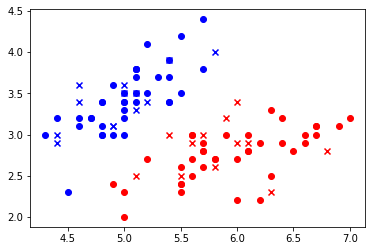

In [28]:
import numpy as np
import pandas as pd
import time
import math
import logging
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from IPython.core import debugger
debug = debugger.Pdb().set_trace

get_ipython().run_line_magic('matplotlib', 'inline')

class Sign(object):
    '''
    阈值分类器
    有两种方向，
        1）x<v y=1
        2) x>v y=1
        v 是阈值轴
    '''
    
    def __init__(self,features,labels,w):
        self.X = features               # 训练数据特征
        
        self.Y = labels                 # 训练数据的标签
        self.N = len(labels)            # 训练数据大小
        self.Xmax=max(features)
        self.w = w                      # 训练数据权值分布
        self.allw=sum(w)                # 一般来说都为1 
        self.v = np.linspace(0,10,41)   # v的可选范围
        
    def _train_less_than_(self):
        '''
        寻找(x<v y=1)情况下的最优v
        '''

        index = -1
        error_score = 100000000

        for v in self.v:
            score = 0
            for j in range(self.N):
                val = -1
                if self.X[j]<v:
                    val = 1

                if val*self.Y[j]<0:
                    score += self.w[j]
            
            
            if score < error_score:   #取值为v，筛选处最优的Gm
                index = v
                error_score = score

        return index,error_score



    def _train_more_than_(self):
        '''
        寻找(x>v y=1)情况下的最优v
        '''

        index = -1
        error_score = 100000000

        for i in self.v:
            score = 0
            for j in range(self.N):
                val = 1
                if self.X[j]<i:
                    val = -1

                if val*self.Y[j]<0:
                    score += self.w[j]
                
            if score < error_score:    #取值为v，筛选处最优的Gm
                index = i
                error_score = score

        return index,error_score

    def train(self):                   #确定是哪种分类器（大于v为1还是小于v为1）
        
        time1 = time.time()
        less_v,less_score = self._train_less_than_()
        more_v,more_score = self._train_more_than_()
        time2 = time.time()
        

        if less_score < more_score:
            self.is_less = True
            self.v = less_v
            return less_score

        else:
            self.is_less = False
            self.v = more_v
            return more_score

    def predict(self,feature):  # Gm(x)  
                                
                                #判断输入的特征在分类器中是一类还是二类（大于v还是小于v为1）
        if self.is_less>0:      #如果是小于v为1的分类器
            if feature<self.v:
                return 1.0       
            else:
                return -1.0
        else:                  #如果是大于v为1的分类器
            if feature<self.v:
                return -1.0
            else:
                return 1.0
            
class AdaBoost(object):
    
    def _init_(self):
        pass
        
    def _init_parameters_(self,features,labels):   #features是特征，labels是标签，要在输入前分开
        self.X = features                          ###特征features的格式是[index,i]的矩阵，该程序中所有index都是行，i都是列###
        self.Y = labels
        self.n = len(features[0])                  #每个数据的特征个数
        
        self.N = len(labels)                       #数据个数
        self.M = 1                                 #训练几次这个程序（无用），为1 即可
        self.w = [1.0/self.N]*self.N               #初始化w为1/N，这就是Di
        self.alpha = []                            #就是公式里的alpha
        self.classifier = []                       #用来存分类器
        self.Z=0
    
    def _w_(self,index,classifier,i):              #计算 wm*e(-alpha*y*g)
                                                   #index是数据的位置，i是数据中特征的序号  
                                    
        return self.w[index]*np.exp(-self.alpha[-1][1]*self.Y[index]*classifier.predict(self.X[index][i]))
    
    def _Z_(self,i,classifier):    #求Zm
        Z=0
        for index in range(self.N):
            Z += self._w_(index,classifier,i)
        return Z                   #返回Zm
    
    def train(self,features,labels):

        self._init_parameters_(features,labels)

        for times in range(self.M):
            logging.debug('iterater %d' % times)
            
            time1 = time.time()
            map_time = 0

                   
            for i in range(self.n):
                print()
                print('正在处理第',i,'个特征')
                best_classifier = (0.5,None,None)  #当前正在定义的分类器(误差率,针对的特征，分类器)
                map_time -= time.time()
                features = self.X[:,i]
                map_time += time.time()
                em=0.5
                self.w = [1.0/self.N]*self.N
                con=0
                while(em>=0.01):                   #100个数据如果没有全部判断对，就不断寻找该特征的分类器
                    
                    classifier = Sign(features,self.Y,self.w)    #分类器
                    error_score = classifier.train()             #分类器的错误率

                    if error_score < best_classifier[0]:         #第一个分类器如果分类器错误率小于0.5，就可以说是一个分类器
                                                                 #只采纳错误率更低的分类器，但是准确率会降低
                    
                    #if error_score < 0.5:                       #所有产生的分类器都采用，不管错误率是比原来高还是低，最终的准确率会提高    
                                                        #这两个if都可以使用，前者分类器少，后者分类器多且准确率高
                        best_classifier = (error_score,i,classifier)
                        print('***第',i,'个特征创建了分类器***')
                        print('该分类器的误差率为：',best_classifier[0])
                    #else:
                        #print('！！第',i,'类没有合适的分类器！！')
                        
                    em = best_classifier[0]
                    #print('该分类器的误差率为：',em)

                    if em==0:
                        alpha=(i,1)                 #self.alpha[a][b],a代表第几个alpha，b为0则显示是哪个特征的alpha，b为1则显示alpha的值
                        self.alpha.append(alpha)
                    else:
                        alpha=(i,0.5*math.log((1-em)/em))
                        self.alpha.append(alpha)

                    self.classifier.append(best_classifier[1:])   
                    #if con>0: 
                        #if self.alpha[-1][1]==self.alpha[-2][1]:
                            #self.classifier=np.delete(self.classifier,-1,axis=0)
                           # break
                
                    con+=1
                    if con>self.N:                #防止陷入死循环，限制分类器的个数
                        print('实在找不到了更好的分类器了')
                        print()
                        break
                    Z = self._Z_(best_classifier[1],best_classifier[2])   #best_classifier[1]表示的是哪一种特征,best_classifier[2]表示的是分类器
                    
                    # 更新训练集权值分布 8.4
                    for ii in range(self.N):
                        self.w[ii] = self._w_(ii,best_classifier[2],best_classifier[1])/Z
                                 
                if (em<0.001):                     #错误率达到标准就可以停止寻找分类器了
                    print('第',i,'类特征的总分类器寻找完毕')
                    print()

            
        #print(self.classifier)       #解除#则可以观看产生的分类器
        alphaspahe=np.shape(self.alpha)
        self.alphanum=alphaspahe[0]
        
        print('一共产生了',self.alphanum,'个分类器')
        print()
        #classifiernum=np.shape(self.classifier)[0]
        
        
       
        
        
    def _predict_(self,featuresnum,testnum,testth,feature):
        result = 0.0
        donateone=0            #分类器投给标签 1 的票数
        donatezero=0           #分类器投给标签-1 的票数
        for i in range(featuresnum):           #第i个特征
            
            for anum in range(self.alphanum):  #每一个分类器都拿出来用
               
                if i==(self.alpha[anum][0]):   #保证使用的分类器是属于这一个特征的
                    result+=self.alpha[anum][1]*self.classifier[anum][1].predict(feature[i])     
            
            if result>0:        #分类器投票
                donateone +=1 
            else:
                donatezero +=1
        if donateone>donatezero:
            return 1
        else:
            return -1
            
        
    def predict(self,features):
        featuresnum=None
        featuresnum=np.shape(features)[1]    #测试集的特征个数
        testnum=np.shape(features)[0]        #测试集的数据个数
        results = []
        
        for testth in range(testnum):        #开始测试第testth个数据为哪一类
            results.append(self._predict_(featuresnum,testnum,testth,features[testth]))
        return results

# 鸢尾花(iris)数据集
# 数据集内包含 3 类共 150 条记录，每类各 50 个数据，
# 每条记录都有 4 项特征：花萼长度、花萼宽度、花瓣长度、花瓣宽度，
# 可以通过这4个特征预测鸢尾花卉属于（iris-setosa, iris-versicolour, iris-virginica）中的哪一品种。
# 这里只取前100条记录，四项特征，两个类别。

def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1,2,3, -1]])
    for i in range(len(data)):
        if data[i,-1] == 0:
            data[i,-1] = -1
    # print(data)
    return data[:,:-1], data[:,-1]  


#开始运行
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
print('Start read data')
time_1=time.time()

X, y = create_data()    #分开数据和标签，X为数据，y为标签
y[y > 0] = 1
y[y == 0] = -1

train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size=0.25, random_state=55)
            
time_2=time.time()
print('读取数据花费了 ',time_2 - time_1,' second','\n')
print('开始训练')


ada = AdaBoost()
ada.train(train_features,train_labels)
#print(ada.alpha)
time_3= time.time()
print('训练花费了 ',time_3 - time_2,' second','\n')

print('开始测试')
test_predict = ada.predict(test_features)
time_4=time.time()

print('测试花费了 ',time_4 - time_3,' second','\n')

score = accuracy_score(test_labels,test_predict)

print("测试准确度为： ", score)
    #def sign(value):
        #if value >:
          #  return 1
      #  else:
         #   return -1
print()
print('点集如下')
plt.scatter(train_features[train_labels==1,0],train_features[train_labels==1,1], marker='o', c='r', label='1')
plt.scatter(train_features[train_labels==-1,0],train_features[train_labels==-1,1], marker='o', c='b', label='-1')
plt.scatter(test_features[test_labels==1,0],test_features[test_labels==1,1], marker='x', c='r')
plt.scatter(test_features[test_labels==-1,0], test_features[test_labels==-1,1], marker='x', c='b')    
        
   

    

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:root:iterater 0


Start read data
read data cost  0.005983829498291016  second 

Start training
正在处理第 0 个特征
***第 0 个特征创建了分类器***
该分类其的em为： 0.12222222222222223
！！第 0 类没有合适的分类器！！
该分类其的em为： 0.12222222222222223
！！第 0 类没有合适的分类器！！
该分类其的em为： 0.12222222222222223
！！第 0 类没有合适的分类器！！
该分类其的em为： 0.12222222222222223
！！第 0 类没有合适的分类器！！
该分类其的em为： 0.12222222222222223
！！第 0 类没有合适的分类器！！
该分类其的em为： 0.12222222222222223
！！第 0 类没有合适的分类器！！
该分类其的em为： 0.12222222222222223
！！第 0 类没有合适的分类器！！
该分类其的em为： 0.12222222222222223
！！第 0 类没有合适的分类器！！
该分类其的em为： 0.12222222222222223
！！第 0 类没有合适的分类器！！
该分类其的em为： 0.12222222222222223
！！第 0 类没有合适的分类器！！
该分类其的em为： 0.12222222222222223
！！第 0 类没有合适的分类器！！
该分类其的em为： 0.12222222222222223
！！第 0 类没有合适的分类器！！
该分类其的em为： 0.12222222222222223
！！第 0 类没有合适的分类器！！
该分类其的em为： 0.12222222222222223
！！第 0 类没有合适的分类器！！
该分类其的em为： 0.12222222222222223
！！第 0 类没有合适的分类器！！
该分类其的em为： 0.12222222222222223
！！第 0 类没有合适的分类器！！
该分类其的em为： 0.12222222222222223
！！第 0 类没有合适的分类器！！
该分类其的em为： 0.12222222222222223
！！第 0 类没有合适的分类器！！
该分类其的em为： 0.12222222222222

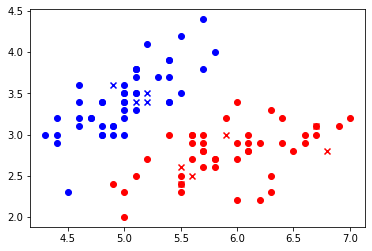

In [3]:
import numpy as np
import pandas as pd
import time
import math
import logging
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from IPython.core import debugger
debug = debugger.Pdb().set_trace

get_ipython().run_line_magic('matplotlib', 'inline')

# 鸢尾花(iris)数据集
# 数据集内包含 3 类共 150 条记录，每类各 50 个数据，
# 每条记录都有 4 项特征：花萼长度、花萼宽度、花瓣长度、花瓣宽度，
# 可以通过这4个特征预测鸢尾花卉属于（iris-setosa, iris-versicolour, iris-virginica）中的哪一品种。
# 这里只取前100条记录，两项特征，两个类别。

class Sign(object):
    '''
    阈值分类器
    有两种方向，
        1）x<v y=1
        2) x>v y=1
        v 是阈值轴
    '''
    
    def __init__(self,features,labels,w):
        self.X = features               # 训练数据特征
        
        self.Y = labels                 # 训练数据的标签
        self.N = len(labels)        # 训练数据大小
        self.Xmax=max(features)
        self.w = w                      # 训练数据权值分布
        self.v = np.linspace(0,10,41)       # 阈值轴可选范围
        
    def _train_less_than_(self):
        '''
        寻找(x<v y=1)情况下的最优v
        '''

        index = -1
        error_score = 100000000

        for v in self.v:
            score = 0
            for j in range(self.N):
                val = -1
                if self.X[j]<v:
                    val = 1

                if val*self.Y[j]<0:
                    score += self.w[j]

            if score < error_score:
                index = v
                error_score = score

        return index,error_score



    def _train_more_than_(self):
        '''
        寻找(x>v y=1)情况下的最优v
        '''

        index = -1
        error_score = 100000000

        for i in self.v:
            score = 0
            for j in range(self.N):
                val = 1
                if self.X[j]<i:
                    val = -1

                if val*self.Y[j]<0:
                    score += self.w[j]

            if score < error_score:    #筛选处最优的Gm
                index = i
                error_score = score

        return index,error_score

    def train(self):                 #确定是哪种分类器（大于v为1还是小于v为1）
        
        time1 = time.time()
        less_v,less_score = self._train_less_than_()
        more_v,more_score = self._train_more_than_()
        time2 = time.time()
        

        if less_score < more_score:
            self.is_less = True
            self.v = less_v
            return less_score

        else:
            self.is_less = False
            self.v = more_v
            return more_score

    def predict(self,feature):  #Gm(x)  
                                #判断输入的特征在分类器中是一类还是二类
        if self.is_less>0:    #如果是小于v为1的分类器
            if feature<self.v:
                return 1.0       
            else:
                return -1.0
        else:                  #如果是大于v为1的分类器
            if feature<self.v:
                return -1.0
            else:
                return 1.0
            
class AdaBoost(object):
    
    def _init_(self):
        pass
        
    def _init_parameters_(self,features,labels):   #features是特征，labels是标签，要在输入前分开
        self.X = features
        self.Y = labels
        self.n = len(features[0])   #特征个数
        
        self.N = len(labels)        #一种特征的数据个数
        self.M = 1
        self.w = [1.0/self.N]*self.N   #初始化w为1/N，这就是Di
        self.alpha = []         
        self.classifier = []
        self.Z=0
    
    def _w_(self,index,classifier,i):    #计算wm+1
                                         #index是数据的位置，i是特征的序号  
                                         #暂时不带Zm
       
        return self.w[index]*np.exp(-self.alpha[-1]*self.Y[index]*classifier.predict(self.X[index][i]))
    
    def _Z_(self,i,classifier):    #求Zm
        
        Z=0

        for index in range(self.N):
            Z += self._w_(index,classifier,i)
            #Z += self.w(index)*np.exp(-self.alpha[-1]*self.Y[index]*classifier.predict(self.X[index][i]))
        return Z
    
    def train(self,features,labels):

        self._init_parameters_(features,labels)

        for times in range(self.M):
            logging.debug('iterater %d' % times)
            
            time1 = time.time()
            map_time = 0

                   
            for i in range(self.n):
                print('正在处理第',i,'个特征')
                best_classifier = (0.5,None,None)  #(误差率,针对的特征，分类器)
                map_time -= time.time()
                features = self.X[:,i]
                map_time += time.time()
                em=0.5
                self.w = [1.0/self.N]*self.N
                con=0
                while(em>=0.01):           #如果没有全部判断对，就不断寻找该特征的多个分类器
                    
                    classifier = Sign(features,self.Y,self.w)    #分类器
                    error_score = classifier.train()             #分类器的错误率

                    if error_score < best_classifier[0]:         #第一个分类器如果分类器错误率小于0.5，就可以说是一个分类器
                                                                 #后面产生的分类器如果不比前一个分类器好，就不是一个分类器
                        best_classifier = (error_score,i,classifier)
                        print('***第',i,'个特征创建了分类器***')
                    else:
                        print('！！第',i,'类没有合适的分类器！！')
                        
                    em = best_classifier[0]
                    print('该分类其的em为：',em)

                    if em==0:
                                    #self.alpha[a][b],a代表第几个alpha，b为0则显示是哪个特征的alpha，b为1则显示alpha的值
                        self.alpha.append(1)
                    else:
                        alpha=0.5*math.log((1-em)/em)
                        self.alpha.append(alpha)

                    self.classifier.append(best_classifier[1:])
                
                    con+=1
                    if con>self.N:       #防止陷入死循环
                        print('实在找不到了')
                        break
                    Z = self._Z_(best_classifier[1],best_classifier[2])   #best_classifier[1]表示的是哪一项特征,
                if (em<0.01):   
                    print('第',i,'类特征的总分类器寻找完毕')                                                      #best_classifier[2]表示的是Gm（x）分类器

            # 更新训练集权值分布 8.4
                    for ii in range(self.N):
                        self.w[ii] = self._w_(ii,best_classifier[2],best_classifier[1])/Z
        print(self.classifier)
        
    def _predict_(self,feature):
        result = 0.0
        for i in range(self.n):
            #for index1 in range(self.n):
                
            index=self.classifier[i][0]     #是哪一个特征的分类器
            classifier = self.classifier[i][1]   #拿出该分类器
            #print(feature)
            #print(feature[index])
            result+=self.alpha[i]*classifier.predict(feature[index])    #分类器f(x)=sign(alpha*Gm(x))
        
        if result>0:    #分类器投票
            return 1 
        else:
            return -1
    def predict(self,features):
        results = []
        for feature in features:
            results.append(self._predict_(feature))
        return results

def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1,2,3, -1]])
    for i in range(len(data)):
        if data[i,-1] == 0:
            data[i,-1] = -1
    # print(data)
    return data[:,:-1], data[:,-1]  


#开始运行
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
print('Start read data')
time_1=time.time()

X, y = create_data()
y[y > 0] = 1
y[y == 0] = -1

train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size=0.1, random_state=65)
            
time_2=time.time()
print('read data cost ',time_2 - time_1,' second','\n')
print('Start training')

ada = AdaBoost()
ada.train(train_features,train_labels)
print(ada.alpha)
time_3= time.time()
print('training cost ',time_3 - time_2,' second','\n')

print('Start predicting')
test_predict = ada.predict(test_features)
time_4=time.time()

print('predicting cost ',time_4 - time_3,' second','\n')

score = accuracy_score(test_labels,test_predict)

print("The accruacy socre is ", score)
    #def sign(value):
        #if value >:
          #  return 1
      #  else:
         #   return -1
plt.scatter(train_features[train_labels==1,0],train_features[train_labels==1,1], marker='o', c='r', label='1')
plt.scatter(train_features[train_labels==-1,0],train_features[train_labels==-1,1], marker='o', c='b', label='-1')
plt.scatter(test_features[test_labels==1,0],test_features[test_labels==1,1], marker='x', c='r')
plt.scatter(test_features[test_labels==-1,0], test_features[test_labels==-1,1], marker='x', c='b')    
        

In [22]:
YYY=X
print(X)

YY=np.delete(YYY,0,axis=1)
print(YY)

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6.9 3.1 4.

alpha is :0.07330173709593753
alpha is :0.19453564916624264
alpha is :0.6051610885090357
alpha is :nan
{'WClassifier0': [4, 5.1, 0.07330173709593753], 'WClassifier1': [4, 5.1, 0.19453564916624264], 'WClassifier2': [4, 5.1, 0.6051610885090357], 'WClassifier3': [4, 5.1, nan]}


e:\newpython\python3.7.6\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


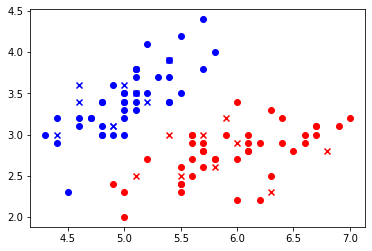

In [66]:
import numpy as np

#Adaboost分类
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier


def calculateAlpha(error):    #Gm(x)的系数
    if error == 0:
        return 0
    else:
        return (1/2) * (np.log((1-error)/error))

def calculateWeight(alpha, originalWeight, y, g):      #更新权重
    weight = originalWeight * (np.e ** (-alpha * y * g))
    return weight

def sign(value):   #  Gm(x)
    if value > 0:
        return 1
    else:
        return -1

def learn(x, alpha, featureValue):
    if x >= featureValue:
        return sign(alpha * 1)
    else:
        return sign(alpha * -1)


def findBestCut(dataset, target, weights):
    shape = np.shape(dataset)
    featureNo = shape[1]
    newWeights = []
    for featureSeq in range(featureNo):   # 4种特征都有各自的分类器
        featureRow = dataset[:, featureSeq]    #提取1种特征
        for featureIndex in range(len(featureRow)):   
            featureValue = featureRow[featureIndex]   #提取特征中的一个值
            resultRow = featureRow.copy()
            for index in range(len(resultRow)):        #resultRow是分类器的分类结果
                if resultRow[index] >= featureValue:
                    resultRow[index] = 1
                else:
                    resultRow[index] = -1

            error = np.dot(np.multiply(resultRow, target), weights.T)   #判断该分类器是否为弱分类器
           
            if error < 0.5:            #如果是弱分类器，那么
                alpha = calculateAlpha(error)
                print('alpha is :' + str(alpha))   #输出权值
                for weightNo in range(len(weights)):
                    g = learn(featureRow[weightNo], alpha, featureValue)    #Gm(x)
                    newWeights.append(calculateWeight(alpha, weights[weightNo], target[weightNo], g))

                newWeights = newWeights / sum(newWeights)
                
                return featureValue, alpha, newWeights
    return None, None, newWeights

    # newWeights = newWeights/sum(newWeights)
    #
    # return featureValue, alpha, newWeights


def adaBoost(dataset,target,weekClassifierNo=4):
    shape = np.shape(dataset)
    
    recordNo = shape[0]
  
    weights = np.ones(recordNo)/recordNo
    featureNo = shape[1]
    weekClassifiers = {}
    for classifierSeq in range(weekClassifierNo):
        featureValue, alpha, newWeights = findBestCut(dataset, target, weights)
        if len(newWeights) == 0:
            break
        weekClassifiers["WClassifier" + str(classifierSeq)] = [featureNo, featureValue, alpha]
        weights = newWeights
    return weekClassifiers

def _predict_(feature):
    result=0.0
    for i in range(4):
        index = 
def predict(features):
    result = []
    for feature in features:
        result.append(_predict_(feature))
    return results
#iris = load_iris()
#iris.target[iris.target > 0] = 1
#iris.target[iris.target == 0] = -1
#train_features=iris.data
#train_labels=iris.target
#print(train_features)
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1,2,3, -1]])
    for i in range(len(data)):
        if data[i,-1] == 0:
            data[i,-1] = -1
    return data[:,:4], data[:,-1]

irisdata,irislabels=create_data()
train_features, text_features, train_labels, test_labels = train_test_split(irisdata, irislabels, test_size=0.18, random_state=55)

weekClassifiers = adaBoost(train_features, train_labels, 50)
print(weekClassifiers)    

plt.scatter(train_features[train_labels==1,0],train_features[train_labels==1,1], 
marker='o', c='r', label='1')
plt.scatter(train_features[train_labels==-1,0],train_features[train_labels==-1,1], 
marker='o', c='b', label='-1')
plt.scatter(text_features[test_labels==1,0],text_features[test_labels==1,1], marker='x', 
c='r')
plt.scatter(text_features[test_labels==-1,0], text_features[test_labels==-1,1], 
marker='x', c='b')


In [68]:
import numpy as np

#Adaboost分类
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier


def calculateAlpha(error):
    if error == 0:
        return 0
    else:
        return (1/2) * (np.log((1-error)/error))

def calculateWeight(alpha, originalWeight, y, g):
    weight = originalWeight * (np.e ** (-alpha * y * g))
    return weight

def sign(value):
    if value > 0:
        return 1
    else:
        return -1

def learn(x, alpha, featureValue):
    if x >= featureValue:
        return sign(alpha * 1)
    else:
        return sign(alpha * -1)


def findBestCut(dataset, target, weights):
    shape = np.shape(dataset)
    featureNo = shape[1]
    newWeights = []
    for featureSeq in range(featureNo):
        featureRow = dataset[:, featureSeq]
        for featureIndex in range(len(featureRow)):
            featureValue = featureRow[featureIndex]
            resultRow = featureRow.copy()
            for index in range(len(resultRow)):
                if resultRow[index] >= featureValue:
                    resultRow[index] = 1
                else:
                    resultRow[index] = -1

            error = np.dot(np.multiply(resultRow, target), weights.T)
           
            if error < 0.5:
                alpha = calculateAlpha(error)
                print('alpha is :' + str(alpha))
                for weightNo in range(len(weights)):
                    g = learn(featureRow[weightNo], alpha, featureValue)
                    newWeights.append(calculateWeight(alpha, weights[weightNo], target[weightNo], g))

                newWeights = newWeights / sum(newWeights)
                
                return featureValue, alpha, newWeights
    return None, None, newWeights

    # newWeights = newWeights/sum(newWeights)
    #
    # return featureValue, alpha, newWeights


def adaBoost(dataset,target,weekClassifierNo=4):
    shape = np.shape(dataset)
    recordNo = shape[0]
    weights = np.ones(recordNo)/recordNo
    featureNo = shape[1]
    weekClassifiers = {}
    for classifierSeq in range(weekClassifierNo):
        featureValue, alpha, newWeights = findBestCut(dataset, target, weights)
        if len(newWeights) == 0:
            break
        weekClassifiers["WClassifier" + str(classifierSeq)] = [featureNo, featureValue, alpha]
        weights = newWeights
    return weekClassifiers

iris = load_iris()
iris.target[iris.target > 0] = 1
iris.target[iris.target == 0] = -1
weekClassifiers = adaBoost(iris.data, iris.target, 50)
print(weekClassifiers)


alpha is :0.09360577104407318
alpha is :0.03509886861946332
alpha is :0.09009038757777348
alpha is :0.2430797244206212
alpha is :0.17190165288528267
alpha is :0.5145727335107108
alpha is :nan
{'WClassifier0': [4, 4.7, 0.09360577104407318], 'WClassifier1': [4, 4.9, 0.03509886861946332], 'WClassifier2': [4, 4.9, 0.09009038757777348], 'WClassifier3': [4, 4.9, 0.2430797244206212], 'WClassifier4': [4, 5.1, 0.17190165288528267], 'WClassifier5': [4, 5.1, 0.5145727335107108], 'WClassifier6': [4, 5.1, nan]}


e:\newpython\python3.7.6\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]
